# **ARIMA-Based Time Series Forecasting Simulator**

How It Works

1. Load Data: Reads the sensor data from a CSV file.
2.	Preprocess Data: Converts timestamps to datetime format and resamples to hourly data.
3.	Check Stationarity: Runs the Augmented Dickey-Fuller (ADF) test to check if differencing is needed.
4.	Fit ARIMA Model: Uses (p=5, d=1, q=0) as an example (can be optimized).
5.	Forecast: Predicts the next 24 hours of sensor readings.
6.	Visualization: Plots both historical data and future predictions.

### **Step 1: Install Required Libraries**

In [ ]:
# Install dependencies
%pip install statsmodels pandas numpy matplotlib scikit-learn pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 487.8 kB/s eta 0:00:00a 0:00:01


### **Step 2: Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm  # Auto ARIMA optimization
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ks_2samp, entropy

### **Step 3: Import Sensor Data CSV file**

In [2]:
# Replace "sensor_data.csv" with your actual dataset file
df = pd.read_csv("../databases/processed_data/cd230831.csv")

# Convert 'datetime' column to pandas datetime format and set as index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [3]:
print(df.columns)

Index(['cooling_channel0', 'cooling_channel1', 'cooling_channel10',
       'cooling_channel11', 'maxigauge_channel1', 'maxigauge_channel2',
       'maxigauge_channel3', 'maxigauge_channel4', 'maxigauge_channel5',
       'maxigauge_channel6', 'temperature_channel1', 'temperature_channel2',
       'temperature_channel5', 'temperature_channel6'],
      dtype='object')


In [4]:
df

,cooling_channel0,cooling_channel1,cooling_channel10,cooling_channel11,maxigauge_channel1,maxigauge_channel2,maxigauge_channel3,maxigauge_channel4,maxigauge_channel5,maxigauge_channel6,temperature_channel1,temperature_channel2,temperature_channel5,temperature_channel6
datetime,,,,,,,,,,,,,,
2023-08-31 00:00:30,15.596670,15.558330,15.542780,15.555560,0.02,0.088700,-1.480000,150.0,710.000000,998.000,293.079000,293.751000,293.731000,0.0
2023-08-31 00:01:00,15.594503,15.558330,15.538204,15.546651,0.02,0.088713,-1.474754,150.0,710.000000,998.000,293.079033,293.751017,293.730633,0.0
2023-08-31 00:01:30,15.592003,15.558330,15.532924,15.536371,0.02,0.088762,-1.455082,150.0,710.000000,998.000,293.080033,293.751517,293.719633,0.0
2023-08-31 00:02:00,15.590465,15.553758,15.537758,15.549443,0.02,0.088800,-1.440000,150.0,710.000000,998.000,293.080951,293.752148,293.709721,0.0
2023-08-31 00:02:30,15.589075,15.548483,15.544148,15.566108,0.02,0.088800,-1.440000,150.0,710.000000,998.000,293.079475,293.756574,293.731361,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-23 23:54:00,15.617176,15.581013,15.533379,15.560624,0.02,0.010300,-0.385098,613.0,721.180328,0.862,283.983883,267.972400,262.406800,0.0
2023-09-23 23:54:30,15.608149,15.574485,15.525739,15.554929,0.02,0.010300,-0.375000,613.0,721.000000,0.862,283.984000,267.973000,262.407000,0.0
2023-09-23 23:55:00,15.599121,15.567958,15.518099,15.549234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Select relevant sensor channels for ARIMA modeling
selected_channels = ["cooling_channel10", "temperature_channel1", "maxigauge_channel3"]

### **Step 4: Check for Stationarity**

In [6]:
def check_stationarity(series):
    adf_test = adfuller(series.dropna())
    print(f"ADF Statistic: {adf_test[0]}, P-value: {adf_test[1]}")
    if adf_test[1] > 0.05:
        print("Data is NOT stationary, applying differencing...")
        return series.diff().dropna()
    else:
        print("Data is already stationary.")
        return series

### **Step 5: Determine Optimal ARIMA Parameters**

In [7]:
def find_best_arima_params(series):
    auto_arima_model = pm.auto_arima(series, seasonal=False, stepwise=True, suppress_warnings=True, trace=True)
    return auto_arima_model.order  # Returns optimal (p, d, q)

### **Step 6: Train ARIMA Model**

In [8]:
forecast_results = {}


Processing ARIMA for cooling_channel10
ADF Statistic: -2.7622966706219945, P-value: 0.06386450990442394
Data is NOT stationary, applying differencing...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-378489.507, Time=15.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-350467.256, Time=2.96 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-352167.054, Time=3.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-357922.436, Time=7.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-350469.256, Time=0.87 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-375903.633, Time=3.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-365066.381, Time=4.97 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-379320.624, Time=33.45 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-365349.424, Time=20.03 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-371300.542, Time=30.02 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-379074.979, Time=20.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : A

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Evaluation Metrics for cooling_channel10:
Mean Absolute Error (MAE): 0.01
Root Mean Squared Error (RMSE): 0.03
Kolmogorov-Smirnov Statistic: 0.5120, p-value: 0.0000
Kullback-Leibler Divergence: inf


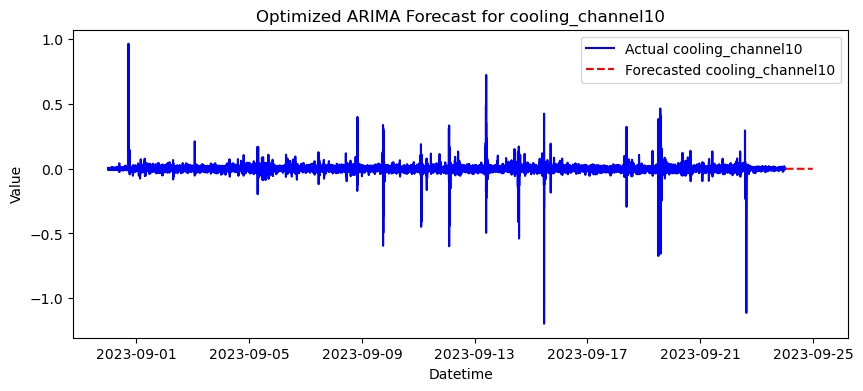


Processing ARIMA for temperature_channel1
ADF Statistic: -2.6153976226661535, P-value: 0.08985646709139655
Data is NOT stationary, applying differencing...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-433995.654, Time=26.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-422305.517, Time=2.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-422598.989, Time=2.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-422931.503, Time=5.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-422307.517, Time=0.93 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-409372.772, Time=18.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-436643.149, Time=17.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-432305.695, Time=10.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-427324.313, Time=3.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-431838.571, Time=20.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-428738.579, Time=4.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati


Evaluation Metrics for temperature_channel1:
Mean Absolute Error (MAE): 0.02
Root Mean Squared Error (RMSE): 0.06
Kolmogorov-Smirnov Statistic: 0.7091, p-value: 0.0000
Kullback-Leibler Divergence: inf


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


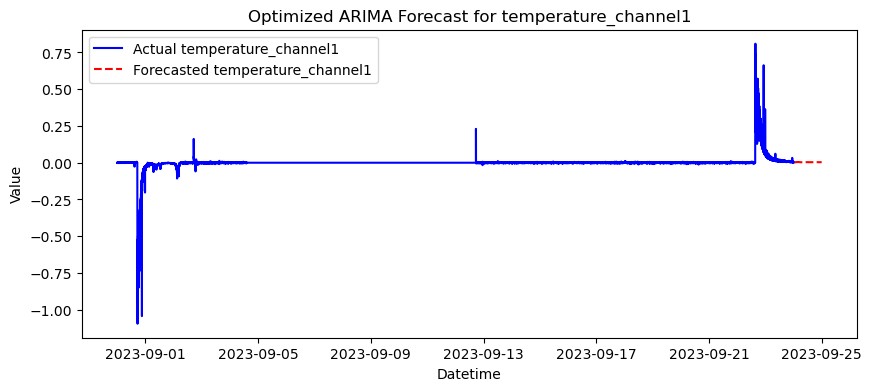


Processing ARIMA for maxigauge_channel3
ADF Statistic: -3.5538588727435028, P-value: 0.00670694789671036
Data is already stationary.
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=267822.013, Time=16.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=351834.411, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=284980.179, Time=1.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=286626.124, Time=4.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=351832.411, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=269698.869, Time=6.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=268422.780, Time=4.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=267931.016, Time=28.78 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=267816.919, Time=15.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=268600.048, Time=5.96 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=267796.071, Time=13.61 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=267574.651, Time=30.40 sec
 A

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: Us


Evaluation Metrics for maxigauge_channel3:
Mean Absolute Error (MAE): 503.95
Root Mean Squared Error (RMSE): 594.73
Kolmogorov-Smirnov Statistic: 0.7255, p-value: 0.0000
Kullback-Leibler Divergence: inf


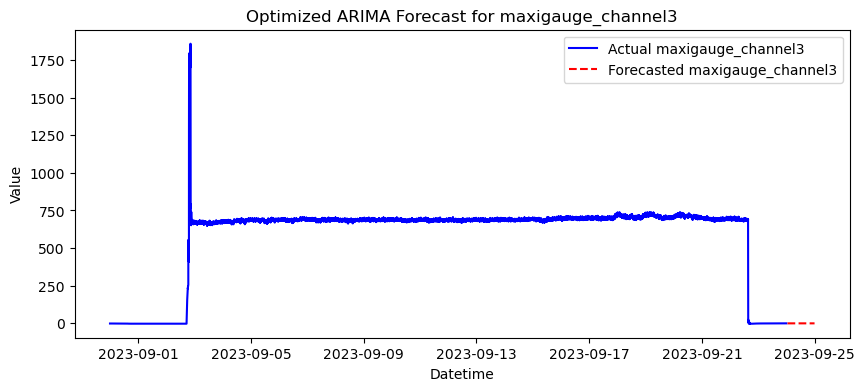

In [9]:
for sensor in selected_channels:
    print(f"\nProcessing ARIMA for {sensor}")
    
    data = df[sensor].dropna()
    
    # Step 4: Check and adjust for stationarity
    data = check_stationarity(data)

    # Step 5: Find optimal ARIMA parameters
    best_order = find_best_arima_params(data)
    print(f"Optimal ARIMA Order for {sensor}: {best_order}")
    
    # Step 6: Train ARIMA model
    model = ARIMA(data, order=best_order)
    model_fit = model.fit()
    
    # Step 7: Forecast next 24 hours
    forecast = model_fit.forecast(steps=24)
    forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(hours=1), periods=24, freq='h')
    forecast_df = pd.DataFrame({'Forecasted Values': forecast.values}, index=forecast_index)
    
    # Store forecast results
    forecast_results[sensor] = forecast_df

    # Step 8: Evaluate Model Performance
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    forecast_test = model_fit.forecast(steps=len(test))

    # Calculate MAE and RMSE
    mae = mean_absolute_error(test, forecast_test)
    rmse = np.sqrt(mean_squared_error(test, forecast_test))
    
    # KS test
    ks_stat, ks_p_value = ks_2samp(test, forecast_test)

    # KL Divergence (requires nonzero values)
    test_nonzero = test + 1e-10  # Avoid log(0)
    forecast_nonzero = forecast_test + 1e-10
    kl_divergence = entropy(test_nonzero, forecast_nonzero)

    # Print evaluation metrics
    print(f"\nEvaluation Metrics for {sensor}:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Kolmogorov-Smirnov Statistic: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")
    print(f"Kullback-Leibler Divergence: {kl_divergence:.4f}")

    # Plot actual vs. forecasted values
    plt.figure(figsize=(10, 4))
    plt.plot(data, label=f"Actual {sensor}", color='blue')
    plt.plot(forecast_df, label=f"Forecasted {sensor}", color='red', linestyle='dashed')
    plt.xlabel("Datetime")
    plt.ylabel("Value")
    plt.title(f"Optimized ARIMA Forecast for {sensor}")
    plt.legend()
    plt.show()
